In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as mc
import copy
import math

import numpy as np
%matplotlib inline

In [ ]:
class PointObject:
    def __init__(self, position):
        self.position = np.array(position)

    def contains(self, point):
        return point == position

    def draw(self, ax):
        plt.scatter(*self.position)
        

class Robot:
    def __init__(self, position):
        self.position = np.array(position)

    def draw(self, ax):
        plt.scatter(*self.position, label='robot', color='g')

        
class Objective:
    def __init__(self, position):
        self.position = np.array(position)

    def draw(self, ax):
        plt.scatter(*self.position, label='objective', 
                    color='m')

        
class RectangleObject(PointObject):
    def __init__(self, position, dimensions):
        super(RectangleObject, self).__init__(position)
        self.dimensions = np.array(dimensions)
    
    def contains(self, point):
        point = np.array(point)
        return np.all(self.position <= point) and np.all(self.position + self.dimensions >= point)
    
    def draw(self, ax):
        rect = patches.Rectangle(self.position, *self.dimensions)
        ax.add_patch(rect)

        
class Map:
    def __init__(self, shape, robot, objective):
        self.shape = np.array(shape)
        self.objects = []
        self.robot = robot
        self.objective = objective
    
    def get_objects_at(self, point):
        return list(filter(lambda x: x.contains(point), self.objects))
    
    def is_object_at(self, point):
        return len(self.get_objects_at(point)) > 0
    
    def add_object(self, o):
        self.objects.append(o)
    
    def contains(self, point):
        point = np.array(point)
        return np.all(0 <= point) and np.all(self.shape >= point)  
    
    def draw(self):
        fig,ax = plt.subplots(1)
        ax.set_xlim([0, self.shape[0]])
        ax.set_ylim([0, self.shape[1]])
        self.robot.draw(ax)
        self.objective.draw(ax)
        for o in self.objects:
            o.draw(ax)
        plt.legend()
        return fig,ax
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

In [ ]:
space = Map((5,5), Robot((0.5,0.5)), Objective((4.5,4.5)))
space.add_object(RectangleObject((2,0), (1, 1)))
space.add_object(RectangleObject((2,2), (1, 1)))
space.add_object(RectangleObject((2,4), (1, 1)))
space.add_object(RectangleObject((1.5,3), (1, 1)))



space.draw();

In [ ]:
#Returns true if the lines intersect:
#https://bryceboe.com/2006/10/23/line-segment-intersection-algorithm/

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect (ABCD are points represented as tuples (x,y))
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

#Checks if AB intersects the top or bottom edge of any of the objects. (We do not need to check if it intersects a side edge)
def intersects_object(A, B, objects):
    for o in objects:
        C = o.position
        D = (o.position[0] + o.dimensions[0], o.position[1])
        if intersect(A, B, C, D):
            return True
        y = o.position[1] + o.dimensions[1]
        C = (o.position[0], y)
        D = (o.position[0] + o.dimensions[0], y)
        if intersect(A, B, C, D):
            return True
        C = o.position
        D = (o.position[0], o.position[1] + o.dimensions[1])
        if intersect(A, B, C, D):
            return True
        x = o.position[0] + o.dimensions[0]
        C = (x, o.position[1])
        D = (x, o.position[1] + o.dimensions[1])
        if intersect(A, B, C, D):
            return True
    #Does not intersect any of the object edges
    return False

In [ ]:
min_reconnect = 100
        reconnect_idx = -1
        for i, v in enumerate(prev_path): #For each vertex in the valid existing path to goal
            if intersects_object(v, point, space.objects): #Do nothing if it intersects an object
                continue
            else: #update variables to keep track of closest connection point
                dist = get_distance(v, point)
                if dist < min_reconnect:
                    reconnect_idx = i
                    min_reconnect = dist
        if reconnect_idx > -1: #Connect the paths
            prev_path = prev_path[0:(reconnect_idx+1)]
            edges.append((point, prev_path[reconnect_idx]))
            parents[tuple(prev_path[reconnect_idx])] = tuple(point)
            goal = point
            break

In [ ]:
#Using Heuristics

def find_nearest_point(points, point):
    point = np.asarray(point)
    return points[np.linalg.norm(points-point, axis=1).argmin()]

# https://github.com/motion-planning/rrt-algorithms/blob/0dde46b4964c6782a2b5126c870367f9072c3381/src/utilities/geometry.py#L31
def path_points(space, edge, point_dist=0.025):
    start, end = np.array(edge[0]), np.array(edge[1])
    dist = np.linalg.norm(end-start)
    n_points = int(np.ceil(dist / point_dist))
    if n_points > 1:
        step = (end-start) / (n_points-1)
        yield from (i * step for i in range(1, n_points))

def is_path_free(space, edge):
    for point in path_points(space, edge):
        if space.is_object_at(point):
            return False
    return True

def random_point(space, vertexes, near_vert_idx, max_dist=0.7, min_dist=0.4):
    while True:
        base_i = np.random.randint(near_vert_idx, len(vertexes))
        base = vertexes[base_i]
        
        randoms = (np.random.uniform(min_dist, max_dist, len(space.shape)))
        signs = [np.random.choice([1,-1]) for _ in range(len(space.shape))]
        
        out = base + randoms * signs
        
        if space.contains(out) and not space.is_object_at(out):
            return out

def construct_path(vertexes, parents, goal, prev_path):
    nearest_point = find_nearest_point(vertexes, goal)
    if intersects_object(nearest_point, goal, space.objects):
        print("Need more iterations to find path")
    point = tuple(nearest_point)
    path = prev_path
    while point is not None:
        path.append(point)
        point = parents[point]
    return prev_path

#Returns the straight line distance from point A to point B
def get_distance(A, B):
    return math.sqrt((B[0] - A[0])**2 + (B[1] - A[1])**2)
    
# Dynamic planning flag    
def RRT(space, prev_path, iterations=100):
    prev_path = get_valid_path(prev_path, space.objects)
    edges = [] #Edges explored
    vertexes = [space.robot.position] #Vertices explored
    parents = {tuple(space.robot.position): None} #Dictionary of parent vertices (child vertex: parent vertex)
    nearest_vert = space.robot.position #Nearest vertex to the goal position (initialize as robot's position)
    near_vert_idx = 0 #Index to keep track of nearest_vert's position in the vertexes list
    
    #Make the goal position be the closest vert in prev_path (or the objective if that is closest)
    goal = space.objective.position
    min_dist = get_distance(nearest_vert, goal)
    if len(prev_path) > 0:
        for v in prev_path:
            dist = get_distance(v, nearest_vert)
            if dist < min_dist:
                min_dist = dist
                goal = v
    
    min_dist = get_distance(nearest_vert, goal) #conatins the closest possible distance to the current goal reached by the tree so far
    
    for _ in range(0, iterations):
        # Generate random_point for RRT (see function for details on the heuristic)
        point = random_point(space, vertexes, near_vert_idx)
        
        #Loop until you get a point that can be validly added to the graph (no object intersections)
        while True:
            nearest_point = find_nearest_point(vertexes, point)
            edge = (nearest_point, point)
    
            #Make sure the new edge does not intersect with an object
            if intersects_object(edge[0], edge[1], space.objects) == False:
                
                #Add information to the tree:
                edges.append(edge)
                vertexes.append(point)
                parents[tuple(point)] = tuple(nearest_point)
                
                #update nearest vertex to goal
                dist = get_distance(point, goal)
                if min_dist > dist:
                    min_dist = dist
                    nearest_vert = point
                    near_vert_idx = len(vertexes)-1
                break
            #Resample point because it was invalid
            else:
                point = random_point(space, vertexes, near_vert_idx)
                continue
            
        #If we are close enough to the current goal, we can break and generate a path:
        if get_distance(vertexes[len(vertexes)-1], goal) < 0.15:
            break
            
        #See if we can connect to the old path (if it exists) via a straight line
        #min_reconnect =
                
            
    #Generate path
    path = construct_path(vertexes, parents, goal, prev_path)
    if path is None:
        return
    
    #Add edges of prev_path to edges list
    for i in range(0, len(prev_path)-1):
        edges.append((prev_path[i], prev_path[i+1]))
        
    return path, edges, vertexes

def get_valid_path(path, objects):
    for i, v in enumerate(path):
        for o in objects:
            if o.contains(v):
                return path[0:i]
    return path
































In [ ]:
#Example 1:
space = Map((5,5), Robot((0.5,0.5)), Objective((4.5,4.5)))
space.add_object(RectangleObject((1,2), (3,1)))
space.draw()

In [ ]:
path, edges, vertexes = RRT(space, [], iterations=1000)
fig, ax = space.draw()

colors = ['r' if tuple(e[1]) not in path else 'b' for e in edges]
lc = mc.LineCollection(edges, colors=colors)
ax.add_collection(lc);

In [ ]:
#Example 2:
space = Map((5,5), Robot((0.5,0.5)), Objective((4.5,4.5)))
space.add_object(RectangleObject((2,2), (3,1)))
space.add_object(RectangleObject((2,4), (1,1)))
space.draw()

In [ ]:
path, edges, vertexes = RRT(space, [], iterations=3000)
fig, ax = space.draw()

colors = ['r' if tuple(e[1]) not in path else 'b' for e in edges]
lc = mc.LineCollection(edges, colors=colors)
ax.add_collection(lc);

In [ ]:
#Worst case example:
space = Map((5,5), Robot((0.5,4.5)), Objective((4.5,4.5)))
space.add_object(RectangleObject((2,2), (1,3)))
space.add_object(RectangleObject((1,2), (1,1)))
space.draw()

In [ ]:
path, edges, vertexes = RRT(space, [], iterations=10000)
fig, ax = space.draw()

colors = ['r' if tuple(e[1]) not in path else 'b' for e in edges]
lc = mc.LineCollection(edges, colors=colors)
ax.add_collection(lc);

In [ ]:
#Add a conflicting object:
space = Map((5,5), Robot((0.5,0.5)), Objective((4.5,4.5)))
space.add_object(RectangleObject((2,2), (1,1)))
space.add_object(RectangleObject((2,4), (1,1)))
space.add_object(RectangleObject((4,2), (1,1)))
path, edges, vertexes = RRT(space, [], iterations=1000)
fig, ax = space.draw()
colors = ['r' if tuple(e[1]) not in path else 'b' for e in edges]
lc = mc.LineCollection(edges, colors=colors)
ax.add_collection(lc);

In [ ]:
#Add conflicting obstacle:
space.add_object(RectangleObject((2,3), (1,1)))

# Run path planning again:
path, edges, vertexes = RRT(space, path, iterations=5000)
fig, ax = space.draw()

colors = ['r' if tuple(e[1]) not in path else 'b' for e in edges]
lc = mc.LineCollection(edges, colors=colors)
ax.add_collection(lc);

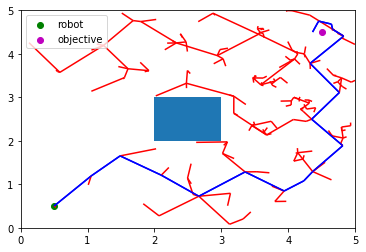

In [145]:
#Add a conflicting object:
space = Map((5,5), Robot((0.5,0.5)), Objective((4.5,4.5)))
space.add_object(RectangleObject((2,2), (1,1)))
path, edges, vertexes = RRT(space, [], iterations=1000)
fig, ax = space.draw()
colors = ['r' if tuple(e[1]) not in path else 'b' for e in edges]
lc = mc.LineCollection(edges, colors=colors)
ax.add_collection(lc);

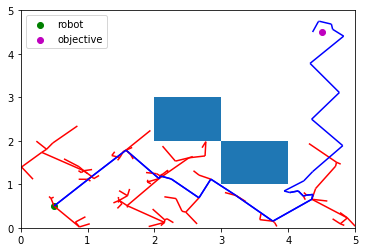

In [146]:
#Add conflicting obstacle:
space.add_object(RectangleObject((3,1), (1,1)))
#space.add_object(RectangleObject((1,3), (1,1)))

# Run path planning again:
path, edges, vertexes = RRT(space, path, iterations=5000)
fig, ax = space.draw()

colors = ['r' if tuple(e[1]) not in path else 'b' for e in edges]
lc = mc.LineCollection(edges, colors=colors)
ax.add_collection(lc);